In [ ]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
boston_data = pd.read_csv(r"https://github.com/selva86/datasets/blob/master/BostonHousing.csv?raw=true")

In [3]:
boston_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
train_data = boston_data.sample(frac=0.80)
test_data = boston_data.drop(train_data.index)

In [5]:
from statistics import mean, stdev

def standardize(column):
    mean_value = mean(column)
    std_value = stdev(column)
    column = [(xi - mean_value)/std_value for xi in column]
    return column

In [6]:
train_data = train_data.apply(standardize, axis=0)      # standardizzo le righe
test_data = test_data.apply(standardize, axis=0)

In [7]:
train_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
486,0.286521,-0.485785,0.977615,-0.277376,0.233659,-0.236511,0.386741,-0.115282,1.667387,1.527712,0.797408,0.393869,0.315951,-0.367290
337,-0.415430,-0.485785,-0.871440,-0.277376,-0.344759,-0.556566,-0.337701,0.873893,-0.515792,-1.082511,0.797408,0.418037,-0.307900,-0.433250
473,0.156968,-0.485785,0.977615,-0.277376,0.497349,1.029094,-0.050793,-0.599567,1.667387,1.527712,0.797408,0.189635,-0.152643,0.809009
430,0.633741,-0.485785,0.977615,-0.277376,0.242165,0.105465,0.612681,-0.829137,1.667387,1.527712,0.797408,-3.114764,0.691390,-0.872988
54,-0.417514,2.689192,-1.041880,-0.277376,-1.237905,-0.566796,-0.768063,1.688859,-0.745600,0.364332,1.207302,0.441751,0.290545,-0.389277


In [8]:
X_train = train_data.drop("medv", axis=1)
y_train = train_data["medv"]
X_test = test_data.drop("medv", axis=1)
y_test = test_data["medv"]

In [ ]:
from keras import regularizers

model = tf.keras.Sequential([
    layers.Input(shape=[X_train.shape[1],]),
    layers.Dense(130, activation="relu"),
    layers.Dense(260, activation=layers.LeakyReLU(negative_slope=0.3)),
    layers.Dropout(0.3),
    layers.Dense(390, activation="relu",
                kernel_regularizer = regularizers.L2(l2=1e-5),
                bias_regularizer = regularizers.L2(1e-5),
                activity_regularizer = regularizers.L2(1e-5)),
    layers.LayerNormalization(),
    layers.Dropout(0.5),
    layers.Dense(260, activation=layers.PReLU()),
    layers.Dense(13, activation="relu"),
    layers.Dense(1)
])

In [10]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_absolute_error", metrics=["mae"])

In [11]:
loss_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [ ]:
checkpoint_model = "./checkpoint.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model,
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

In [ ]:
boston_history = model.fit(
    X_train,
    y_train,
    shuffle=True,
    epochs=50,
    validation_split=0.15,
    verbose=1,
    callbacks=[loss_callback, val_loss_callback, checkpoint_callback]
)

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
loss, mae

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2873 - mae: 0.2622 


(0.3263505697250366, 0.30139869451522827)

In [ ]:
y_pred = model.predict(X_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fb21c50ee80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
print(y_test.shape)
print(y_pred.shape)


(101,)
(101, 1)


In [ ]:
y_pred = y_pred.flatten()

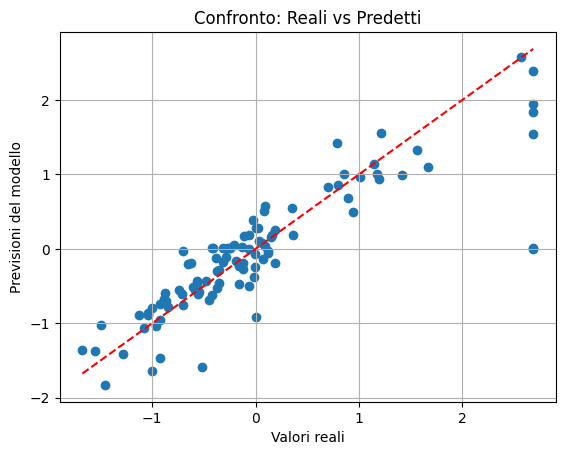

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valori reali")
plt.ylabel("Previsioni del modello")
plt.title("Confronto: Reali vs Predetti")
plt.grid()
plt.show()